# Introduction to Computer Vision - Lab 08

## Lab task
Create functions that implement forward and backpropagation through the convolutional nodes shown on slide 34 of Lecture Notes 8.

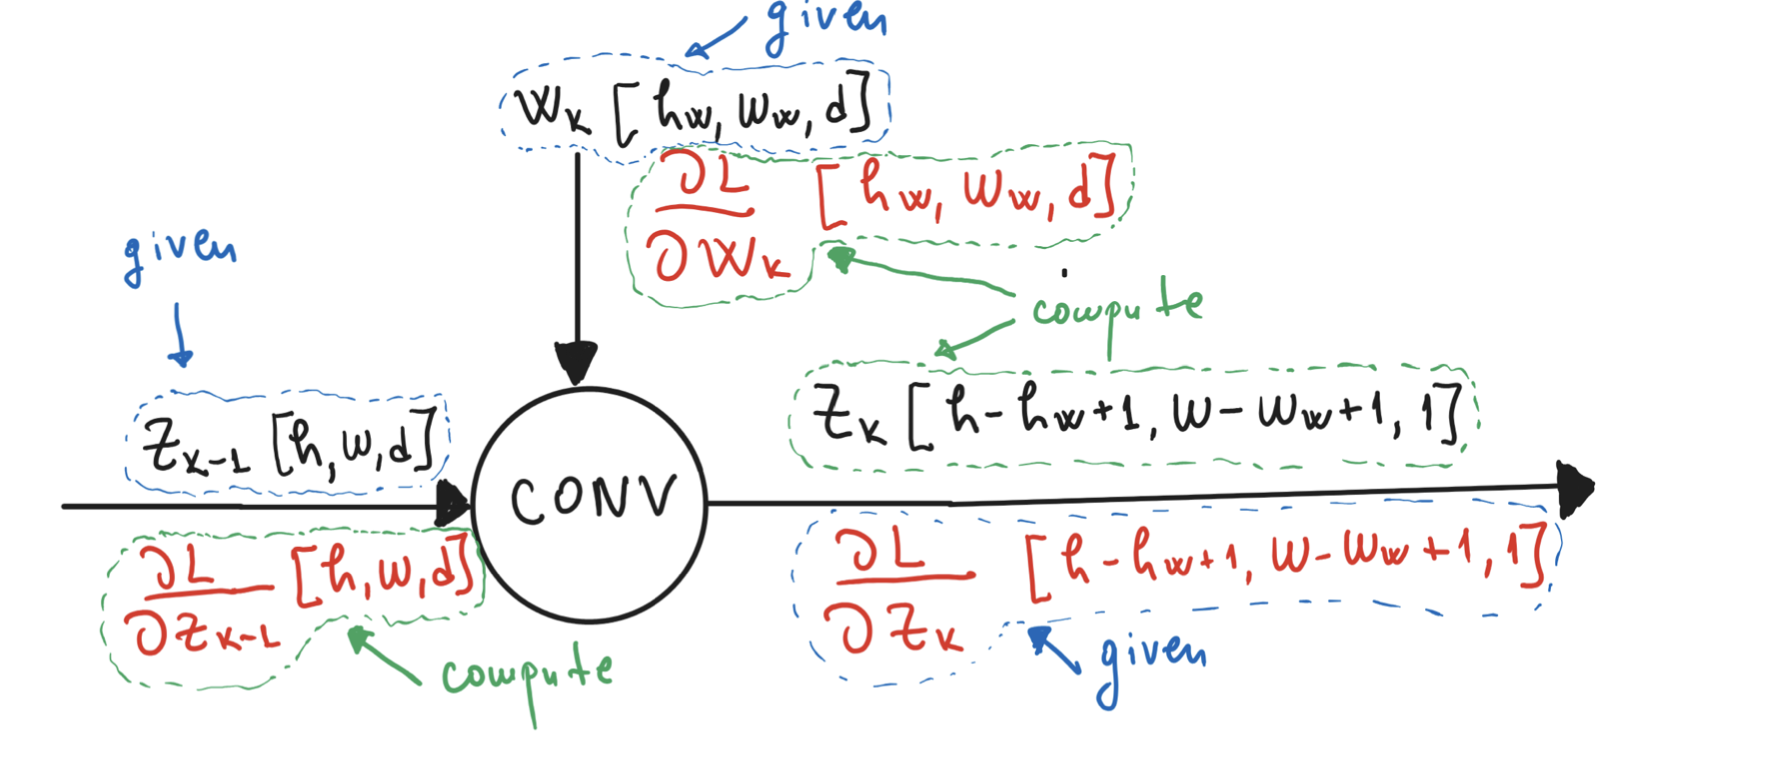

In [1]:
import numpy as np

In [2]:
# Class representing the Convolutional Node
class ConvNode:

    def __init__(self):
        self.Zk_prev = None # the previous feature map
        self.Wk = None # the filter

    def forward(self, Zk_prev, Wk):
        # Forward propagation
        self.Zk_prev = Zk_prev
        self.Wk = Wk

        # Apply convolution operation
        depth, h, w = self.Zk_prev.shape
        _, hw, ww = self.Wk.shape

        Zk_h = h - hw + 1
        Zk_w = w - ww + 1
        Zk_d = 1

        Zk = np.zeros((Zk_h, Zk_w, Zk_d))

        for d in range(depth):
            Zk[:, :, 0] += self.convolve(self.Zk_prev[d, :, :], self.Wk[d, :, :])

        return Zk

    def backward(self, dL_dZk):
        # Bacward propagation
        dL_dWk = np.zeros_like(self.Wk)
        dL_dZk_prev = np.zeros_like(self.Zk_prev)
        dL_dZk = dL_dZk.reshape(dL_dZk.shape[1], dL_dZk.shape[2])

        # Compute gradients using formulas (5) and (9) from lecture slides

        for d_i in range(self.Wk.shape[0]):
            dL_dWk[d_i, :, :] = self.convolve(self.Zk_prev[d_i, :, :], dL_dZk)
            dL_dZk_prev[d_i, :, :] = self.convolve(self.pad(dL_dZk, (self.Wk.shape[1]-1, self.Wk.shape[2]-1)),
                                                   self.rotate(self.Wk[d_i, :, :]))
        return dL_dWk, dL_dZk_prev

    def convolve(self, X, W):
        # Convolution operation between X and W that produces the matrix Z
        h, w = X.shape
        hw, ww = W.shape

        Z_h = h - hw + 1
        Z_w = w - ww + 1
        Z = np.zeros((Z_h, Z_w))

        for i in range(Z_h):
            for j in range(Z_w):
                Z[i, j] = np.sum(X[i:i+hw, j:j+ww] * W)

        return Z

    def rotate(self, Z):
        # Rotate the matrix Z by 180 degrees
        return np.flip(np.flip(Z, 1), 0)

    def pad(self, Z, pad_size):
        # Pad the matrix Z with zeros
        return np.pad(Z, pad_size)

### Check the results using any build-in functions
Using any library/package you wish, find and propose build-in functions that perform the same functions as those you created in 1. To show this, you need to show that for given inputs, these build-in functions produce the same outputs as the functions you created in 1.


In [3]:
import torch
import torch.nn.functional as F

In [4]:
# Some example
Zk_prev = np.array([[[1, 2, 3],
                     [4, 5, 6],
                     [7, 8, 9]],

                    [[10, 11, 12],
                     [13, 14, 15],
                     [16, 17, 18]],

                    [[19, 20, 21],
                     [22, 23, 24],
                     [25, 26, 27]]])

Wk = np.array([[[0, 1],
                [1, 0]],

               [[1, 0],
                [1, 0]],

               [[1, 1],
                [1, 0]]])

print('The result of forward propagation (my implementation):')
conv_node = ConvNode()
Zk = conv_node.forward(Zk_prev, Wk)

print('Zk:')
print(Zk.reshape(Zk.shape[0], Zk.shape[1]))
print('------------------------------------------------------')

print('The result of forward propagation using pytorch library:')
Zk_prev_tensor = torch.from_numpy(Zk_prev).unsqueeze(0).float()
Wk_tensor = torch.from_numpy(Wk).unsqueeze(0).float()
output = F.conv2d(Zk_prev_tensor, Wk_tensor)
print('Zk:')
print(output.numpy().squeeze())

The result of forward propagation (my implementation):
Zk:
[[ 90.  97.]
 [111. 118.]]
------------------------------------------------------
The result of forward propagation using pytorch library:
Zk:
[[ 90.  97.]
 [111. 118.]]


As can be seen, the results of forward propagation are the same for my implementation and for pytorch solution.

In [5]:
# Some example of value dL_dZk
dL_dZk = np.array([[[ 1, 1],
                    [0, 2]]])

dL_dWk, dL_dZk_prev = conv_node.backward(dL_dZk)

# Print the gradients
print("Gradient with respect to Wk:")
print(dL_dWk)
print('------------------------------------------------------')

print("Gradient with respect to Wk (pytorch):")
dL_dZk_tensor = torch.from_numpy(dL_dZk).unsqueeze(0).float()

grad_Wk = torch.nn.grad.conv2d_weight(Zk_prev_tensor, Wk_tensor.shape, dL_dZk_tensor)
print(grad_Wk.numpy().squeeze())

Gradient with respect to Wk:
[[[ 13  17]
  [ 25  29]]

 [[ 49  53]
  [ 61  65]]

 [[ 85  89]
  [ 97 101]]]
------------------------------------------------------
Gradient with respect to Wk (pytorch):
[[[ 13.  17.]
  [ 25.  29.]]

 [[ 49.  53.]
  [ 61.  65.]]

 [[ 85.  89.]
  [ 97. 101.]]]


In [6]:
print("Gradient with respect to Zk_prev:")
print(dL_dZk_prev)
print('------------------------------------------------------')

print("Gradient with respect to Zk_prev (pytorch):")
dL_dZk_tensor = torch.from_numpy(dL_dZk).unsqueeze(0).float()

grad_Zk_prev = torch.nn.grad.conv2d_input(Zk_prev_tensor.shape, Wk_tensor, dL_dZk_tensor)
print(grad_Zk_prev.numpy().squeeze())

Gradient with respect to Zk_prev:
[[[0 1 1]
  [1 1 2]
  [0 2 0]]

 [[1 1 0]
  [1 3 0]
  [0 2 0]]

 [[1 2 1]
  [1 3 2]
  [0 2 0]]]
------------------------------------------------------
Gradient with respect to Zk_prev (pytorch):
[[[0. 1. 1.]
  [1. 1. 2.]
  [0. 2. 0.]]

 [[1. 1. 0.]
  [1. 3. 0.]
  [0. 2. 0.]]

 [[1. 2. 1.]
  [1. 3. 2.]
  [0. 2. 0.]]]


As can be seen, the results of backward propagation are the same for my implementation and for pytorch solution.